In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import tensorflow as tf
import gc

**Данный ноутбук создан из смеси найденного для демонстрации ноута и своих решений по аугментации и обучению и созданию модели**

# Загрузка данных соревнования

Вначале загрузить в Ноут токен кагл

In [ ]:
# Загрузка датасета с Кеггла
!pip install kaggle -q
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.12 -q 
!kaggle --version

cp: cannot stat 'kaggle.json': No such file or directory
Kaggle API 1.5.12


In [ ]:
!kaggle competitions download -c mds-mipt-dl-test-final
!unzip '/content/mds-mipt-dl-test-final.zip' -d'/content/mds-mipt-dl-test/'

 90% 15.0M/16.7M [00:00<00:00, 33.3MB/s]
100% 16.7M/16.7M [00:00<00:00, 33.7MB/s]
Archive:  /content/mds-mipt-dl-test-final.zip
replace /content/mds-mipt-dl-test/fmnist_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
main_file = '/content/mds-mipt-dl-test/fmnist_train.csv'
test_file  = '/content/mds-mipt-dl-test/fmnist_test.csv'

main_data = pd.read_csv(main_file, index_col='Id')
main_data.dropna(inplace = True)
test_data = pd.read_csv(test_file, index_col='Id')

In [ ]:
print("Fashion MNIST main -  rows:",main_data.shape[0]," columns:", main_data.shape[1])
print("Fashion MNIST test -  rows:",test_data.shape[0]," columns:", test_data.shape[1])

Fashion MNIST main -  rows: 17039  columns: 785
Fashion MNIST test -  rows: 10000  columns: 784


## <a id="41">Class distribution</a>

Let's see how many number of images are in each class. We start with the train set.

### Main set images class distribution


There are 10 different classes of images, as following: 

* **0**: **T-shirt/top**;   
* **1**: **Trouser**;   
* **2**: **Pullover**;   
* **3**: **Dress**;
* **4**: **Coat**;
* **5**: **Sandal**;
* **6**: **Shirt**;
* **7**: **Sneaker**;
* **8**: **Bag**;
* **9**: **Ankle boot**.

Image dimmensions are **28**x**28**.   

The train set and test set are given in two separate datasets.


In [ ]:
# Create a dictionary for each type of label 
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

def get_classes_distribution(data):
    # Get the count for each label
    label_counts = data["label"].value_counts()

    # Get total number of samples
    total_samples = len(data)


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))

get_classes_distribution(main_data)

T-shirt/top         :   1770 or 10.387933564176302%
Sneaker             :   1761 or 10.335113563002524%
Dress               :   1725 or 10.123833558307412%
Shirt               :   1704 or 10.000586888901932%
Trouser             :   1700 or 9.977111332824697%
Ankle Boot          :   1694 or 9.941897998708844%
Sandal              :   1694 or 9.941897998708844%
Pullover            :   1677 or 9.842126885380598%
Bag                 :   1675 or 9.830389107341981%
Coat                :   1639 or 9.619109102646869%


The classes are equaly distributed in the train set (10% each). Let's check the same for the test set.    
Let's also plot the class distribution.



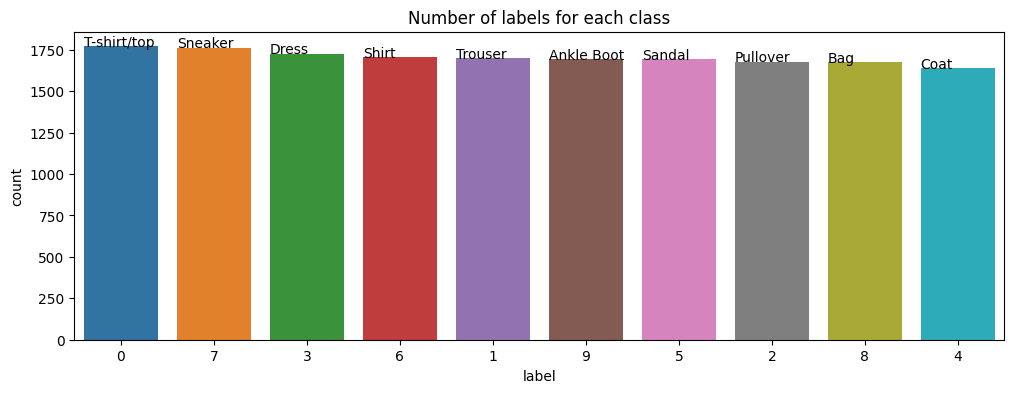

In [ ]:
def plot_label_per_class(data):
    f, ax = plt.subplots(1,1, figsize=(12,4))
    g = sns.countplot(data, x=data.label, order = data["label"].value_counts().index)
    g.set_title("Number of labels for each class")

    for p, label in zip(g.patches, data["label"].value_counts().index):
        g.annotate(labels[label], (p.get_x(), p.get_height()+0.1))
    plt.show()  
    
plot_label_per_class(main_data)

# <a id="5">Split data</a>

We start with preparing the model.

In [ ]:
from sklearn.model_selection import train_test_split

We process both the train_data and the test_data

## Split train in train and validation set

We further split the train set in train and validation set. The validation set will be 20% from the original train set, therefore the split will be train/validation of 0.8/0.2.

In [ ]:
train_data, val_data =train_test_split(main_data, test_size=0.2,
                                       random_state=1313, 
                                       stratify=main_data['label'])

The dimmension of the processed train, validation and test set are as following:

In [ ]:
print("Fashion MNIST train -  rows:", train_data.shape[0]," columns:", train_data.shape[1:4])
print("Fashion MNIST valid -  rows:", val_data.shape[0]," columns:", val_data.shape[1:4])


Fashion MNIST train -  rows: 13631  columns: (785,)
Fashion MNIST valid -  rows: 3408  columns: (785,)


In [ ]:
# переводим в картинки
x_train = train_data.iloc[:,1:].to_numpy().reshape((train_data.shape[0], 28, 28))[:, :, :, np.newaxis]
y_train = train_data['label'].to_numpy()
x_val = val_data.iloc[:,1:].to_numpy().reshape((val_data.shape[0], 28, 28))[:, :, :, np.newaxis]
y_val = val_data['label'].to_numpy()


Let's check the class inbalance for the rsulted training set.

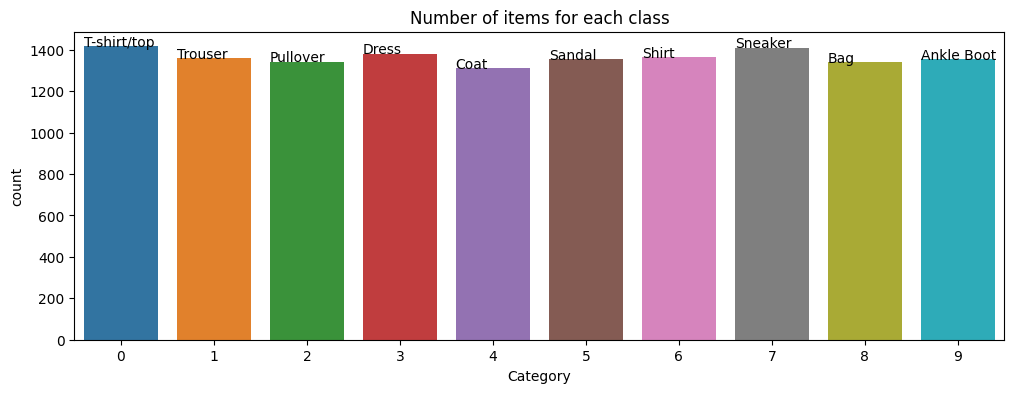

T-shirt/top         :   1416 or 10.388085980485657%
Sneaker             :   1409 or 10.336732448096251%
Dress               :   1380 or 10.123982099625852%
Shirt               :   1363 or 9.999266378108723%
Trouser             :   1360 or 9.977257721370405%
Ankle Boot          :   1355 or 9.940576626806545%
Sandal              :   1355 or 9.940576626806545%
Pullover            :   1342 or 9.845205780940503%
Bag                 :   1340 or 9.830533343114958%
Coat                :   1311 or 9.61778299464456%


In [ ]:
def plot_count_per_class(yd):
    ydf = pd.DataFrame(yd)
    f, ax = plt.subplots(1,1, figsize=(12,4))
    g = sns.countplot(x = ydf[0], order = np.arange(0,10))
    g.set_title("Number of items for each class")
    g.set_xlabel("Category")
    
    for p, label in zip(g.patches, np.arange(0,10)):
        g.annotate(labels[label], (p.get_x(), p.get_height()+0.1))
        
    plt.show()  

def get_count_per_class(yd):
    ydf = pd.DataFrame(yd)
    # Get the count for each label
    label_counts = ydf[0].value_counts()

    # Get total number of samples
    total_samples = len(yd)


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))
    
plot_count_per_class(y_train)
get_count_per_class(y_train)

And, as well, for the validation set.

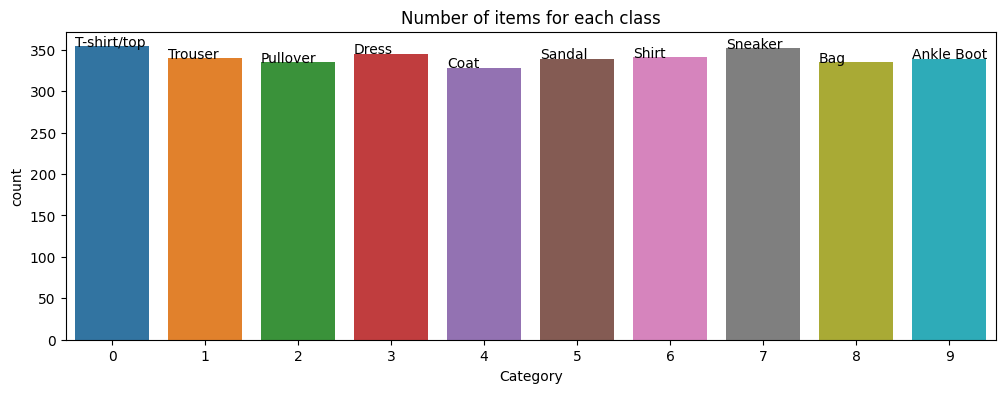

T-shirt/top         :   354 or 10.387323943661972%
Sneaker             :   352 or 10.328638497652582%
Dress               :   345 or 10.123239436619718%
Shirt               :   341 or 10.00586854460094%
Trouser             :   340 or 9.976525821596244%
Ankle Boot          :   339 or 9.94718309859155%
Sandal              :   339 or 9.94718309859155%
Bag                 :   335 or 9.82981220657277%
Pullover            :   335 or 9.82981220657277%
Coat                :   328 or 9.624413145539906%


In [ ]:
plot_count_per_class(y_val)
get_count_per_class(y_val)

Both the train and validation set are unbalanced with respect of distribution of classes. 

# Своя аугментация

In [ ]:
from numpy.core.fromnumeric import resize
from scipy.ndimage import rotate
import cv2

def gaussian_noise(x, mu = 0.0, std= 0.05):
    noise = np.random.normal(mu, std, size = x.shape)
    x_noisy = x + noise
    return x_noisy 



def setagum_img(img, simple_agum = True):
    """
    Функция создания аугментированных картинок
    """
    # яркость и котраст
    #f not simple_agum and np.random.random()>0.65: 
      # define the contrast and brightness value
      #contrast = np.random.randint(100,127) # Contrast control ( 0 to 127)
      #brightness = np.random.randint(90,100) # Brightness control (0-100)

      # call addWeighted function. use beta = 0 to effectively only
      #img = img.reshape((28, 28))
      #img = cv2.addWeighted(img, contrast, img, 0, brightness).reshape((28, 28, 1))

    # зеркальные версии
    aug_imgs = [img]
    aug_imgs.extend(list(map(lambda x: np.flip(x,axis=1), aug_imgs)))
    if not simple_agum:
      aug_imgs.extend(list(map(lambda x: np.flip(x,axis=0), aug_imgs)))
      #aug_imgs.extend(list(map(lambda x: np.rot90(x), aug_imgs)))
    id = np.random.randint(len(aug_imgs))
    out_img = aug_imgs[id]

    # шум
    if np.random.random()>0.7:
      out_img = gaussian_noise(out_img)
    
    # малые углы
    if np.random.random()>0.5:
      rad = 10 if not simple_agum else 2
      ang = np.random.randint(0, rad)
      if np.random.random()>0.5: ang*=-1
      out_img = rotate(out_img, angle=ang)



    # обрезка
    if np.random.random()<0.3: out_img = out_img[:28,:28,:]
    elif 0.6>np.random.random()>=0.3: out_img = out_img[-28:,-28:,:]
    else:
      out_img = cv2.resize(img, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
      out_img = np.expand_dims(out_img,axis=-1)

    return out_img

## Train start agum

In [ ]:
classes, start_qty = np.unique(y_train, return_counts = True)
id_max_label = start_qty.argmax()
# получаем максимальный класс
max_label = start_qty[id_max_label]
max_label, id_max_label

(1416, 0)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
# копируем для дополенения
agum_x_train = x_train.copy()
agum_y_train = y_train.copy()
NUM_CLASSES = 10

# вес для коррекции в какие то класы
WEIGHT_AGUM = [1.3, 1., 1.3, 1., 1.3, 1., 1.3, 1., 1., 1.]

for cls in tqdm(range(NUM_CLASSES), unit ="class",
                desc ="Проходимся по классам"): # проходимся по популяциям
  # размер текущего класса
  size_label = train_data[train_data['label'] == cls].shape[0]
  # разница с максимальным классом
  qty_agum = int((max_label - size_label)*WEIGHT_AGUM[cls])
  if qty_agum:
    for _ in tqdm(range(qty_agum), unit ="add",
                desc = f"Пополняем класс {cls}"): # проходимся по к-ву дополнения
      element = train_data[train_data['label'] == cls].sample()
      # переводим в картинку
      aug_imag = element.iloc[:,1:].to_numpy().reshape((28, 28, 1))
      # меняем картинку
      aug_imag = setagum_img(aug_imag)
      # добавляем картинку и метку в набор
      agum_x_train = np.vstack((agum_x_train, aug_imag[np.newaxis, :, :, :]))
      agum_y_train = np.hstack((agum_y_train, element['label'].to_numpy()))



Проходимся по классам:   0%|          | 0/10 [00:00<?, ?class/s]

Пополняем класс 1:   0%|          | 0/56 [00:00<?, ?add/s]

Пополняем класс 2:   0%|          | 0/96 [00:00<?, ?add/s]

Пополняем класс 3:   0%|          | 0/36 [00:00<?, ?add/s]

Пополняем класс 4:   0%|          | 0/136 [00:00<?, ?add/s]

Пополняем класс 5:   0%|          | 0/61 [00:00<?, ?add/s]

Пополняем класс 6:   0%|          | 0/68 [00:00<?, ?add/s]

Пополняем класс 7:   0%|          | 0/7 [00:00<?, ?add/s]

Пополняем класс 8:   0%|          | 0/76 [00:00<?, ?add/s]

Пополняем класс 9:   0%|          | 0/61 [00:00<?, ?add/s]

In [ ]:
np.unique(agum_y_train, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1416, 1416, 1438, 1416, 1447, 1416, 1431, 1416, 1416, 1416]))

In [ ]:
agum_x_train.shape

(14228, 28, 28, 1)

## Val start agum

In [ ]:
classes, start_qty = np.unique(y_val, return_counts = True)
id_max_label = start_qty.argmax()
# получаем максимальный класс
max_label = start_qty[id_max_label]
max_label, id_max_label

(354, 0)

In [ ]:
# копируем для дополенения
agum_x_val = x_val.copy()
agum_y_val = y_val.copy()

for cls in tqdm(range(NUM_CLASSES), unit ="class",
                desc ="Проходимся по классам"): # проходимся по популяциям
  # размер текущего класса
  size_label = val_data[val_data['label'] == cls].shape[0]
  # разница с максимальным классом
  qty_agum = int((max_label - size_label)*WEIGHT_AGUM[cls])
  if qty_agum:
    for _ in tqdm(range(qty_agum), unit ="add",
                desc = f"Пополняем класс {cls}"): # проходимся по к-ву дополнения
      element = val_data[val_data['label'] == cls].sample()
      # переводим в картинку
      aug_imag = element.iloc[:,1:].to_numpy().reshape((28, 28, 1))
      # меняем картинку
      aug_imag = setagum_img(aug_imag)
      # добавляем картинку и метку в набор
      agum_x_val = np.vstack((agum_x_val, aug_imag[np.newaxis, :, :, :]))
      agum_y_val = np.hstack((agum_y_val, element['label'].to_numpy()))



Проходимся по классам:   0%|          | 0/10 [00:00<?, ?class/s]

Пополняем класс 1:   0%|          | 0/14 [00:00<?, ?add/s]

Пополняем класс 2:   0%|          | 0/24 [00:00<?, ?add/s]

Пополняем класс 3:   0%|          | 0/9 [00:00<?, ?add/s]

Пополняем класс 4:   0%|          | 0/33 [00:00<?, ?add/s]

Пополняем класс 5:   0%|          | 0/15 [00:00<?, ?add/s]

Пополняем класс 6:   0%|          | 0/16 [00:00<?, ?add/s]

Пополняем класс 7:   0%|          | 0/2 [00:00<?, ?add/s]

Пополняем класс 8:   0%|          | 0/19 [00:00<?, ?add/s]

Пополняем класс 9:   0%|          | 0/15 [00:00<?, ?add/s]

In [ ]:
np.unique(agum_y_val, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([354, 354, 359, 354, 361, 354, 357, 354, 354, 354]))

In [ ]:
agum_x_val.shape

(3555, 28, 28, 1)

## <a id="42">Sample images</a>

### Train set images

Let's plot some samples for the images.   
We add labels to the train set images, with the corresponding fashion item category.  

In [ ]:
IMG_ROWS,IMG_COLS = 28, 28

In [ ]:
def sample_images_from_df(data, qty_smpl):
    # An empty list to collect some samples
    sample_images = []
    sample_labels = []

    # Iterate over the keys of the labels dictionary defined in the above cell
    for k in labels.keys():
        # Get four samples for each category
        samples = data[data["label"] == k].head(qty_smpl)
        # Append the samples to the samples list
        for j, s in enumerate(samples.values):
            # First column contain labels, hence index should start from 1
            img = np.array(samples.iloc[j, 1:]).reshape(IMG_ROWS,IMG_COLS)
            sample_images.append(img)
            sample_labels.append(samples.iloc[j, 1])

    print("Total number of sample images to plot: ", len(sample_images))
    return sample_images, sample_labels

train_sample_images, train_sample_labels = sample_images_from_df(train_data, 4)

Total number of sample images to plot:  40


Let's now plot the images.   
The labels are shown above each image.

In [ ]:
def plot_sample_images(data_sample_images,data_sample_labels,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(5,8, figsize=(16,10))

    for i, img in enumerate(data_sample_images):
        if len(img.shape) == 2:
          ax[i//8, i%8].imshow(img, cmap=cmap)
        else: ax[i//8, i%8].imshow(img.reshape((28,28)), cmap=cmap)
        ax[i//8, i%8].axis('off')
        ax[i//8, i%8].set_title(labels[data_sample_labels[i]])
    plt.show()    

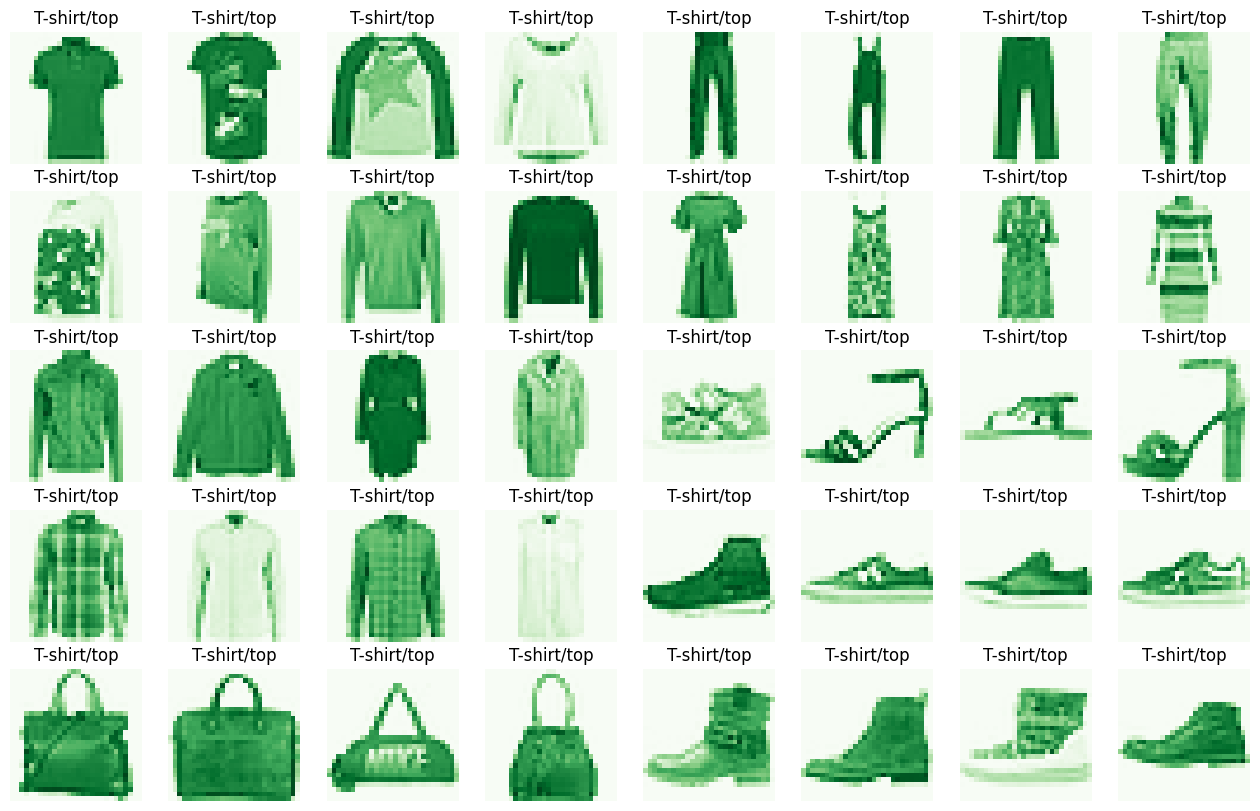

In [ ]:
plot_sample_images(train_sample_images, train_sample_labels, "Greens")

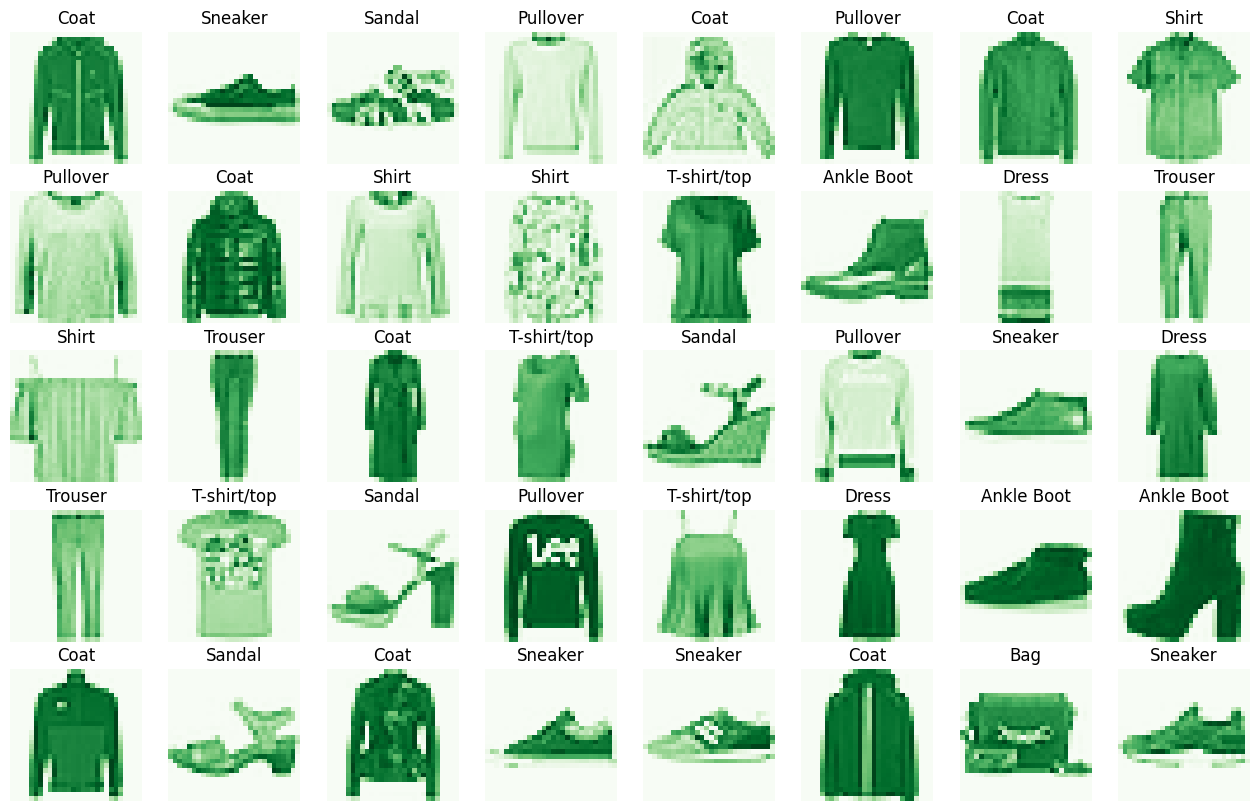

In [ ]:
idx = np.random.randint(0, agum_y_train.shape[0], 40)
plot_sample_images(agum_x_train[idx], agum_y_train[idx], "Greens")

# Build the model



In [ ]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - activ - функция актвации на выходном слое
    - input_shape - размерность карты сегментации
'''
def unet(num_classes = 3,
         activ = 'softmax',
         input_shape= (88, 120, 3)):
    lay = tf.keras.layers
    img_input = lay.Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Block 1
    x = lay.Conv2D(32, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = lay.BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = lay.Activation('relu')(x)                                              # Добавляем слой Activation

    x = lay.Conv2D(32, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = lay.BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = lay.Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = lay.MaxPooling2D()(block_1_out)                                        # Добавляем слой MaxPooling2D

    # Block 2
    x = lay.Conv2D(64, (3, 3), padding='same', name='block2_conv1')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = lay.BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = lay.Activation('relu')(x)                                              # Добавляем слой Activation

    x = lay.Conv2D(64, (3, 3), padding='same', name='block2_conv2')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = lay.BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = lay.Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = lay.MaxPooling2D()(block_2_out)                                        # Добавляем слой MaxPooling2D

    # Block 3
    x = lay.Conv2D(128, (3, 3), padding='same', name='block3_conv1')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = lay.BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = lay.Activation('relu')(x)                                              # Добавляем слой Activation

    x = lay.Conv2D(128, (3, 3), padding='same', name='block3_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = lay.BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = lay.Activation('relu')(x)                                              # Добавляем слой Activation

    x = lay.Conv2D(128, (3, 3), padding='same', name='block3_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = lay.BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out = lay.Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out
    
    #x = lay.MaxPooling2D(pool_size = (7, 7))(block_3_out)                                        # Добавляем слой MaxPooling2D
    
    # Block 4
    #x = lay.Conv2D(256, (3, 3), padding='same', name='block4_conv1')(x)        # Добавляем Conv2D-слой с 256-нейронами
    #x = lay.BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    #x = lay.Activation('relu')(x)                                              # Добавляем слой Activation

    #x = lay.Conv2D(256, (3, 3), padding='same', name='block4_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    #x = lay.BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    #x = lay.Activation('relu')(x)                                              # Добавляем слой Activation

    #x = lay.Conv2D(256, (3, 3), padding='same', name='block4_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    #x = lay.BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    #block_4_out = lay.Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out
    #x = block_4_out                                                           # Добавляем слой MaxPooling2D

    # UP 2
    #x = lay.Conv2DTranspose(256, (7, 7), strides=(7, 7), padding='same')(x)    # Добавляем слой Conv2DTranspose с 128 нейронами
    #x = lay.BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    #x = lay.Activation('relu')(x)                                              # Добавляем слой Activation

    #x = lay.concatenate([x, block_3_out])                                      # Объединем текущий слой со слоем block_2_out
    #x = lay.Conv2D(256, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
    #x = lay.BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    #x = lay.Activation('relu')(x)                                              # Добавляем слой Activation

    #x = lay.Conv2D(256, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 128 нейронами
    #x = lay.BatchNormalization()(x) # Добавляем слой BatchNormalization
    #x = lay.Activation('relu')(x) # Добавляем слой Activation

    # UP 3
    x = lay.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 128 нейронами
    x = lay.BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = lay.Activation('relu')(x)                                              # Добавляем слой Activation

    x = lay.concatenate([x, block_2_out])                                      # Объединем текущий слой со слоем block_2_out
    x = lay.Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
    x = lay.BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = lay.Activation('relu')(x)                                              # Добавляем слой Activation

    x = lay.Conv2D(128, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 128 нейронами
    x = lay.BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = lay.Activation('relu')(x) # Добавляем слой Activation

    # UP 4
    x = lay.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = lay.BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = lay.Activation('relu')(x) # Добавляем слой Activation

    x = lay.concatenate([x, block_1_out])  # Объединем текущий слой со слоем block_1_out
    x = lay.Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = lay.BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = lay.Activation('relu')(x) # Добавляем слой Activation

    x = lay.Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = lay.BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = lay.Activation('relu')(x) # Добавляем слой Activation

    x = lay.Conv2D(num_classes, (3, 3), activation=activ, padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = tf.keras.Model(img_input, x) # Создаем модель с входом 'img_input' и выходом 'x'

    
    return model # Возвращаем сформированную модель

In [ ]:
unet_model = unet(num_classes = 10,
         activ = 'sigmoid',
         input_shape= (28, 28, 1))
unet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 28, 28, 32)   320         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_13 (BatchN  (None, 28, 28, 32)  128         ['block1_conv1[0][0]']           
 ormalization)                                                                                    
                                                                                                  
 activation_13 (Activation)     (None, 28, 28, 32)   0           ['batch_normalization_13[0]

In [ ]:
def classify_model(num_classes = 3,
                activ = 'softmax',
                input_shape = (32, 32, 3)):

  
    lay = tf.keras.layers  
    input = lay.Input(shape = input_shape)
    out = lay.LayerNormalization()(input)
    out = lay.MaxPooling2D()(out) 
    out = lay.Flatten()(out)    
    out = lay.Dense(512, activation='relu')(out)
    # Add dropouts to the model
    out = lay.Dropout(0.35)(out)
    out = lay.Dense(256, activation='relu')(out)
    out = lay.Dropout(0.5)(out)
    out = lay.Dense(num_classes, activation=activ)(out)
    model = tf.keras.Model(inputs = input, outputs = out)
    return model

class_model = classify_model(NUM_CLASSES,
                                  activ = 'softmax',
                                  input_shape = (28, 28, 10))
# Отображение сводки модели
class_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 10)]      0         
                                                                 
 layer_normalization_1 (Laye  (None, 28, 28, 10)       20        
 rNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 10)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1960)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               1004032   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0   

In [ ]:
encoder_input = tf.keras.layers.Input(shape=(28, 28, 1), name='img')
unet_out = unet_model(encoder_input)
classes = class_model(unet_out)
network_fashon = tf.keras.Model(encoder_input, classes)

In [ ]:
network_fashon.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 model_3 (Functional)        (None, 28, 28, 10)        1004074   
                                                                 
 model_4 (Functional)        (None, 10)                1137950   
                                                                 
Total params: 2,142,024
Trainable params: 2,139,720
Non-trainable params: 2,304
_________________________________________________________________


Let's also plot the model

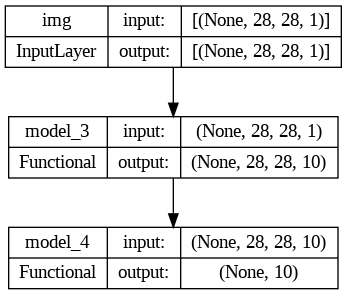

In [ ]:
tf.keras.utils.plot_model(network_fashon, show_shapes = True)


# DATA generator custom 

In [ ]:
def images_norm(imgs):
  return (imgs - np.min(imgs)) / (np.max(imgs) - np.min(imgs) + 0.0001)
  #return imgs/255. - 0.5

class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, x_data, y_data, norm: object, batch_size, agum = False, simple_agum = True):
    self.x, self.y = x_data, y_data
    self.batch_size = batch_size
    self.agum = agum
    self.simple_agum = simple_agum
    self.num_batches = np.ceil(len(x_data) / batch_size)
    self.batch_idx = np.array_split(range(len(x_data)), self.num_batches)
    self.norm = norm

  def __len__(self):
    return len(self.batch_idx)

  def __getitem__(self, idx):
    batch_x = self.x[self.batch_idx[idx]].astype(float) # / 255 - 
    batch_x = self.norm(batch_x)
    if self.agum:
      batch_x = np.array([setagum_img(img, self.simple_agum) for img in batch_x])
    
    batch_y = self.y[self.batch_idx[idx]]

    return tf.convert_to_tensor(batch_x), tf.convert_to_tensor(batch_y)

In [ ]:
# one-hot encode для ответов

y_train_oh = tf.keras.utils.to_categorical(agum_y_train, NUM_CLASSES)
y_val_oh = tf.keras.utils.to_categorical(agum_y_val, NUM_CLASSES)

print(y_train_oh.shape)
print(y_train_oh[:5])
print(y_train[:5])

(14228, 10)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[2 3 6 3 4]


In [ ]:
BATCH = 2
train_datagen = DataGenerator(agum_x_train, y_train_oh, 
                                      images_norm,
                                      batch_size = BATCH,
                                      agum = True, simple_agum=False)
val_datagen = DataGenerator(agum_x_val, y_val_oh, images_norm, batch_size = BATCH)

In [ ]:
res = val_datagen.__getitem__(1)
res[0].shape, res[1].shape

(TensorShape([2, 28, 28, 1]), TensorShape([2, 10]))

# Корневая папка

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
# Корневая папка на диске для работы с заданием - которую вы должны создать себе и указать
os.chdir('/content/drive/Othercomputers/My_comp/Documents/МФТИ - Наука о данных/Глубокое обучение DL/') # папку на диске создайте заранее
os.getcwd()

'/content/drive/Othercomputers/My_comp/Documents/МФТИ - Наука о данных/Глубокое обучение DL'

 # Load trained model 

In [ ]:
saved_path_model = 'Задания/Model_next_cnn_4/'  # куда пишет weights

In [ ]:
network_fashon = tf.keras.models.load_model(saved_path_model, compile=False)


# Show callback custom

In [ ]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt  # Отображение графиков
import types
import inspect
from scipy.stats import mode  # для нахождения чаще встречающегося ответа по классу


class ClassificationCallback(tf.keras.callbacks.Callback):
    """ Callback for classification"""

    def __init__(self, metrics=[], step=1, class_metrics = 'best',  data_tag = 'images',             
                 show_worst=False, show_final=True, validation_data = [], name_classes = []):
        """
        Init for classification callback

        Args:
            metrics (list):         список используемых метрик (по умолчанию metrics = list()), что соответсвует 'loss'
            class_metrics:          вывод графиков метрик по каждому сегменту: class_metrics (по умолчанию 'best',
                                    если  = [], то не будет справа выводить)
            step int():             шаг вывода хода обучения, по умолчанию step = 1
            show_worst bool():      выводить ли справа отдельно, плохие метрики, по умолчанию False
            show_final bool ():     выводить ли в конце обучения график, по умолчанию True

        Returns:
            None
        """
        super().__init__()
        self.step = step
        self.metrics = metrics
        self.show_worst = show_worst
        self.show_final = show_final
        self.class_metrics = class_metrics
        self.data_tag = data_tag
        self.validation_data = validation_data
        self.name_classes = name_classes
        pass

    def plot_result(self, idx, hist_classes):
        """
        Returns:
            None:
        """

        # округление к большему
        def grossround(x): 
            if (x - int(x) < 0.5) and (x != int(x)):
                return round(x+1)
            else:
                return round(x) 
        m = 1
        l = 1
        k = 1
        if len(self.losses) > 1: # если больше 1й метрики было указано , то графики выведет
            if len(self.class_metrics) == 1 and self.class_metrics[0] != 'best':
                #ищем в metrics индекс запрощенной в class_metrics[0] метрики
                idx = self.losses.index(self.class_metrics[0])
            
            # определяем, что демонстрируем во 2м и 3м окне
            showmet = self.losses[idx]
            vshowmet = f'val_{showmet}'
            epochcomment = f' epoch {str(self.epoch + 1)}'

            # набираем окна от условий
            k += 1 
            if self.class_metrics: #
                k += 1    
            plt.figure(1, figsize=(7*k, 5))
            plt.subplot(m,k,l)
            plt.title(f'loss and val_loss{epochcomment}')
            plt.plot(self.history['loss'], label='loss')
            plt.plot(self.history['val_loss'], label='val_loss')
            plt.grid()
            plt.legend(loc='lower left');   

            # выводим точность по одной из списка class_metrics, по умолчанию 'best'
            if  self.class_metrics: 
                titlecomment = f'{str(self.losses[idx])} metric = {str(showmet)} and {str(vshowmet)+epochcomment}'
                l += 1
                plt.subplot(m,k,l)
                plt.title(titlecomment)
                plt.plot(self.history[showmet], label=str(showmet))
                plt.plot(self.history[vshowmet], label=str(vshowmet))
                plt.grid()
                plt.legend(loc='lower left');   


            # выводим точность по классам если были данны метрики и запрос на вывод
            if hist_classes:
                l += 1
                plt.subplot(m,k,l)
                plt.title(f'F1 of {str(self.classes)} classes {epochcomment}')
                for j in range(self.classes):
                    label = f'class {str(j)}' if not self.name_classes else self.name_classes[j]
                    plt.plot(hist_classes[vshowmet][idx][j], label = label)  
                plt.legend(loc='lower left')   
                plt.grid()
            plt.show()

            if hist_classes and self.show_final:
                if 'best' in self.class_metrics:
                    grafics = len(self.class_metrics) - 1
                else:
                    grafics = len(self.class_metrics)

                k = 3
                m = grossround(grafics/k)
                
                plt.figure(1, figsize=(7*k, 5*m))
                for l in range(1, grafics):
                    #print('metka 5')
                    plt.subplot(m,k,l)
                    idx = l-1
                    vshowmet = 'val_'+ self.losses[idx]
                    plt.title(f'F1 of {str(self.classes)} classes {epochcomment}')
                    for j in range(self.classes):
                        label = f'class {str(j)}' if not self.name_classes else self.name_classes[j]
                        plt.plot(hist_classes[vshowmet][idx][j], label= label)
                    plt.legend(loc='lower left')                     
                    plt.grid()
                plt.show()   
        else:
            pass
        pass

    # Распознаём тестовую выборку и выводим результаты
    def recognizeclasses(self, y_pred, y_true):
        # определяем классы
        predsegments = np.argmax(y_pred, axis=-1)
        truesegments = np.argmax(y_true, axis=-1)

        acc_classes = []
        for j in range(self.classes):
            tp = 0
            fp = 0
            fn = 0

            for i in range(y_true.shape[0]):
                cross = predsegments[i][predsegments[i] == truesegments[i]]
                tp += cross[cross == j].size # истинно положительные
              
                uncross = predsegments[i][predsegments[i] != truesegments[i]]
                fp += uncross[uncross == j].size # ложно положительные

                uncross = truesegments[i][truesegments[i] != predsegments[i]]
                fn += uncross[uncross == j].size # ложно отрицательные 
                recall = (tp+1)/(tp+fp+1)
                precize = (tp+1)/(tp+fn+1)

                f1 = 2*precize*recall/(precize + recall)
            acc_classes.append(f1)
        return acc_classes


    def on_train_begin(self, logs={}):
        """

        Returns:
            None:
        """
        # 'loss' в metrics выдает ошибку в colab
        self.losses = self.metrics.copy()
        # расширяем добавляя 'loss' 
        self.losses.append('loss')
        self.acc_met = [[] for i in range(len(self.losses))]
        self.acc_valmet = [[] for i in range(len(self.losses))]
        self.history = {} # словарь для сбора стандартного history
        self.predict_cls = {} # словарь для сбора истории предикта по классам и метрикам
        if self.validation_data: 
            self.classes = self.validation_data.y.shape[-1] # количество классов
            self.acls_lst = [[[] for i in range(self.classes)] for i in range(len(self.losses))] # 
        pass    

    def on_epoch_end(self, epoch, logs={}):
        """
        Returns:
            {}:
        """

        m_acc = 0
        self.epoch = epoch
        for i in range(len(self.losses)):
            # проверяем есть ли метрика заданная функцией
            if type(self.losses[i]) == types.FunctionType:
               met = self.losses[i].__name__
               self.losses[i] = met
            else:
               met = self.losses[i]
            vmet = 'val_' + met
            # определяем лучшую метрику для вывода данных при class_metrics='best'
            if logs[vmet] > m_acc:
                m_acc = logs[vmet]
                self.idx = i
            # собираем в словарь по метрикам
            self.acc_met[i].append(logs[met])
            self.acc_valmet[i].append(logs[vmet])
            dm = {str(met): self.acc_met[i]}
            self.history.update(dm)
            dv = {str(vmet): self.acc_valmet[i]}
            self.history.update(dv)

            if self.validation_data:            
                # получаем y_pred и y_true
                y_pred = self.model.predict(self.validation_data.x, verbose = 0)
                y_true = self.validation_data.y
                # распознаем и выводим результат по классам
                res_lst = self.recognizeclasses(y_pred, y_true)
                # собираем в словарь по метрикам и классам
                dclsup = {}
                for j in range(self.classes):
                    self.acls_lst[i][j].append(res_lst[j])
                dcls = {str(vmet): self.acls_lst}
                dclsup.update(dcls)
                self.predict_cls.update(dclsup)

        if self.epoch % self.step == 0 and self.epoch > 0:
            self.comment = ' epoch '+str(epoch + 1)
            # для 0 и 1 метрики покажет 0 индекс для вывода графика
            if len(self.losses) <= 2: 
                self.idx = 0
            # если не был подан validation
            if self.validation_data == []: 
                self.classes = 0
                self.predict_cls ={}
            self.bstmet = self.losses[self.idx]
            clear_output()
            self.plot_result(self.idx, self.predict_cls)
        pass  

        return  self.predict_cls

    def on_train_end(self, logs={}):
            if self.show_final == True:
                self.comment = f'on {str(self.epoch + 1)} epochs'
                # для 0 и 1 метрики покажет 0 индекс
                if len(self.losses) <= 2:
                    self.idx = 0
                # если не дан val набор, то не будет вывода по метрикам
                if self.validation_data == []:     
                    self.classes = 0
                    self.predict_cls ={}
                self.bstmet = self.losses[self.idx]
                clear_output()
                self.plot_result(self.idx, self.predict_cls)
            else:
                pass
    
    

In [ ]:
BATCH = 32
train_datagen = DataGenerator(agum_x_train, y_train_oh,
                                      images_norm,
                                      batch_size = BATCH,
                                      agum = True, simple_agum = False)
val_datagen = DataGenerator(agum_x_val, y_val_oh,
                            images_norm,
                            batch_size = BATCH,
                            agum = True, simple_agum = True,
                            )

# Стартовое обучение модели на уменьшение Loss

In [ ]:
model_save_path = 'Задания/Model_next_cnn_4/'  # куда пишет weights

In [ ]:
# понижение шага 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 mode='min',
                                                 factor = 0.8, 
                                                 patience = 3,
                                                 min_lr = 1e-9,
                                                 verbose = 1)

# остановка
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True
    )

# Сохранение модели
checkpoint  = tf.keras.callbacks.ModelCheckpoint(
                        filepath = model_save_path,
                        #save_weights_only=True,
                        monitor='val_loss',
                        mode='min',
                        save_best_only=True
                        )

metrics = ['acc'] 
hist_classes = ClassificationCallback(metrics = metrics, step = 3,
                                      class_metrics=['acc'],
                                      show_final=True,
                                      validation_data =  val_datagen,
                                      name_classes=list(labels.values())
                                      ) 

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
# очистка ОЗУ 
clear_ozu = GarbageCollectorCallback()

In [ ]:
network_fashon.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = 'acc' 
)

### Run the model

We run the model with the training set. We are also using the validation set (a subset from the orginal training set) for validation.

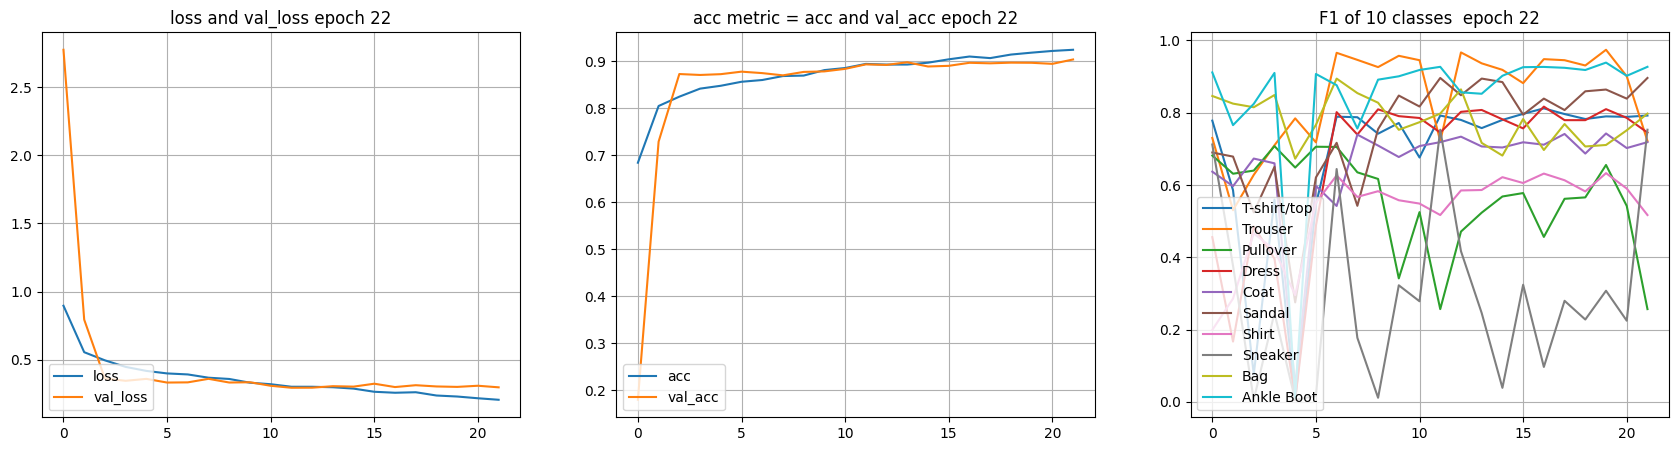

<Figure size 2100x500 with 0 Axes>

In [ ]:
BATCH = 64

history = network_fashon.fit(
          train_datagen, 
          epochs=200,
          validation_data = val_datagen,
          callbacks=[early_stopping, reduce_lr,
                      checkpoint, clear_ozu, hist_classes],                     
          shuffle = True
)

# Дообучение модели на увеличение ACC

In [ ]:
# понижение шага 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc',
                                                 mode='max',
                                                 factor = 0.8, 
                                                 patience = 3,
                                                 min_lr = 1e-9,
                                                 verbose = 1)

# остановка
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
    )

# Сохранение модели
checkpoint  = tf.keras.callbacks.ModelCheckpoint(
                        filepath = model_save_path,
                        #save_weights_only=True,
                        monitor='val_acc',
                        mode='max',
                        save_best_only=True
                        )

metrics = ['acc'] 
hist_classes = ClassificationCallback(metrics = metrics, step = 3,
                                      class_metrics=['acc'],
                                      show_final=True,
                                      validation_data =  val_datagen,
                                      name_classes=list(labels.values())
                                      ) 

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
# очистка ОЗУ 
clear_ozu = GarbageCollectorCallback()

In [ ]:
BATCH = 16
train_datagen = DataGenerator(agum_x_train, y_train_oh,
                                      images_norm,
                                      batch_size = BATCH,
                                      agum = True, simple_agum = True)
val_datagen = DataGenerator(agum_x_val, y_val_oh,
                            images_norm,
                            agum = True, simple_agum = True,
                            batch_size = BATCH)

In [ ]:
network_fashon.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0001),
    metrics = 'acc' 
)

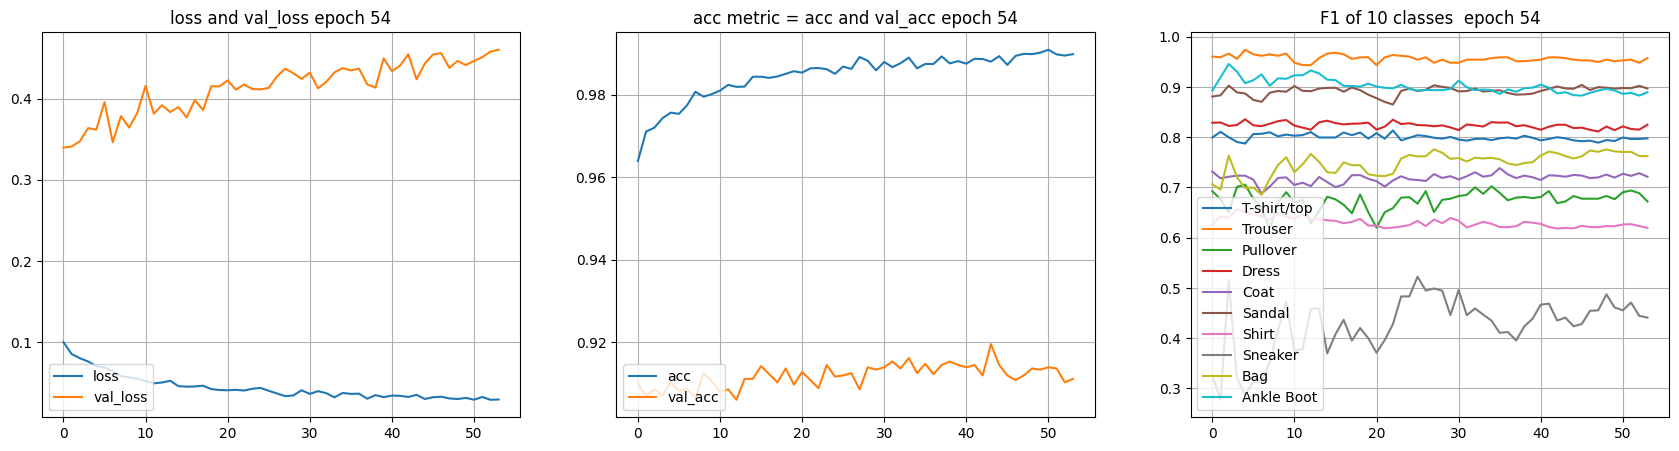

<Figure size 2100x500 with 0 Axes>

In [ ]:
history = network_fashon.fit(
          train_datagen, 
          epochs=100,
          validation_data = val_datagen,
          callbacks=[early_stopping, reduce_lr,
                      checkpoint, clear_ozu, hist_classes],                     
          shuffle = True
)

### Дообучение используя CyclicalLearningRate и SGD

In [ ]:
# дополнительная библиотека tensorflow_addons
!pip install -q -U tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.5 MB/s eta 0:00:00


In [ ]:
import tensorflow_addons as tfa
INIT_LR = 4e-6
MAX_LR = 1e-4

BATCH = 16
steps_per_epoch = len(agum_x_train) // BATCH

# понижение шага циклами
clr = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_mode = 'cycle',
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)
# оптимизатор
#optimizer = tf.keras.optimizers.SGD(clr)
optimizer = tf.keras.optimizers.Adam(clr)
# функция потерь
network_fashon.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer= optimizer,
    metrics = 'acc' 
)

# остановка
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc', 
    verbose=1,
    patience=25,
    mode='max',
    restore_best_weights=True
    )

class show_learning(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        # -5189  in scientific notation results in  “5.189e+3”
        lr = "{:e}".format(np.float16(lr))
        print(f', lr - {lr}')

show_lr = show_learning()

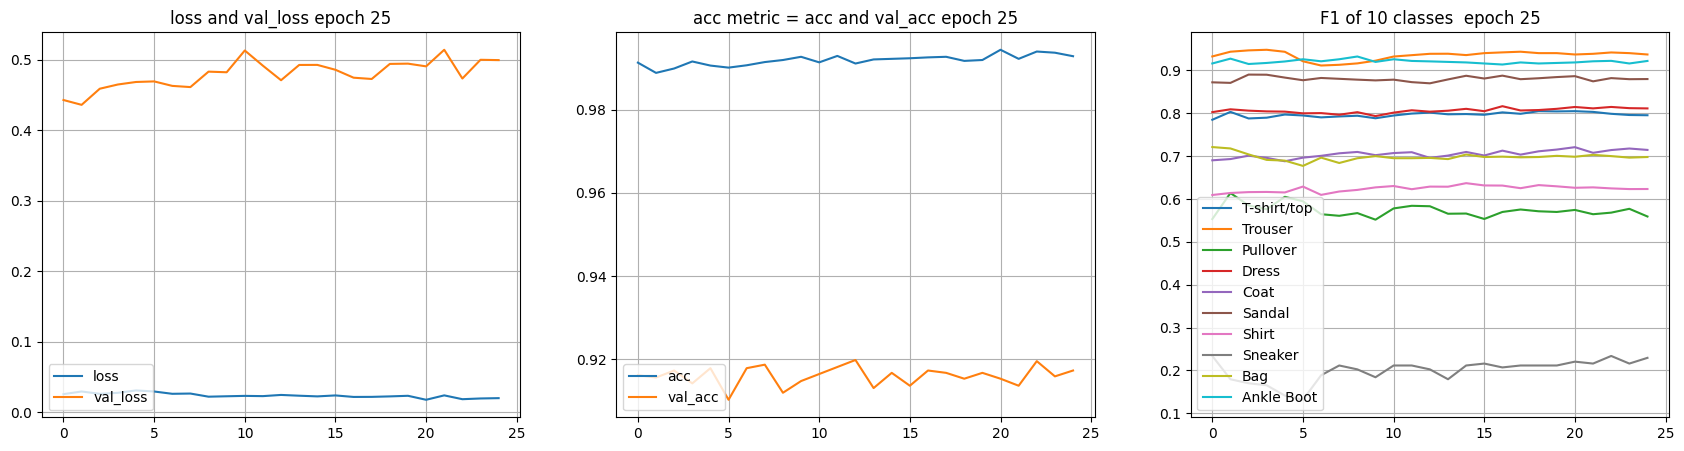

<Figure size 2100x500 with 0 Axes>

, lr - 4.768372e-06
890/890 [==============================] - 21s 23ms/step - loss: 0.0201 - acc: 0.9928 - val_loss: 0.4992 - val_acc: 0.9173
Epoch 26/100
889/890 [============================>.] - ETA: 0s - loss: 0.0224 - acc: 0.9922

In [ ]:
history = network_fashon.fit(
          train_datagen, 
          epochs=100,
          validation_data = val_datagen,
          callbacks=[early_stopping, checkpoint,
                     clear_ozu, hist_classes, show_lr],                     
          shuffle = True
)

# <a id="53">Validation accuracy and loss</a>

Let's plot the train and validation accuracy and loss, from the train history.

In [ ]:
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [ ]:
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['acc']
    val_acc = hist['val_acc']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
   
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                               'Training and validation loss'))
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])

    
    iplot(fig, filename='accuracy-loss')

plot_accuracy_and_loss(history)

/usr/local/lib/python3.10/dist-packages/plotly/tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [ ]:
score = network_fashon.evaluate(images_norm(x_val),
                                tf.keras.utils.to_categorical(y_val,NUM_CLASSES),
                                verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.48454350233078003
Test accuracy: 0.9219483733177185


In [ ]:
val_to_pred = x_val.reshape((x_val.shape[0], 28, 28))[:,:, :, np.newaxis]
val_to_pred = images_norm(val_to_pred)
pred_y_val = np.argmax(network_fashon.predict(val_to_pred), axis = 1)

107/107 [==============================] - 42s 391ms/step


In [ ]:
p = pred_y_val
y = y_val
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

In [ ]:
print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 3142
Incorrect predicted classes: 266


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
target_names = ["Class {} ({}) :".format(i, labels[i]) for i in range(NUM_CLASSES)]
print(classification_report(y_val, pred_y_val, target_names=target_names))

                         precision    recall  f1-score   support

Class 0 (T-shirt/top) :       0.85      0.89      0.87       354
    Class 1 (Trouser) :       1.00      1.00      1.00       340
   Class 2 (Pullover) :       0.89      0.89      0.89       335
      Class 3 (Dress) :       0.91      0.92      0.91       345
       Class 4 (Coat) :       0.88      0.87      0.88       328
     Class 5 (Sandal) :       0.98      0.98      0.98       339
      Class 6 (Shirt) :       0.76      0.74      0.75       341
    Class 7 (Sneaker) :       0.97      0.98      0.97       352
        Class 8 (Bag) :       0.99      0.97      0.98       335
 Class 9 (Ankle Boot) :       0.99      0.97      0.98       339

               accuracy                           0.92      3408
              macro avg       0.92      0.92      0.92      3408
           weighted avg       0.92      0.92      0.92      3408



## <a id="6">Visualize classified images</a>

## <a id="61">Correctly classified images</a>


We visualize few images correctly classified.

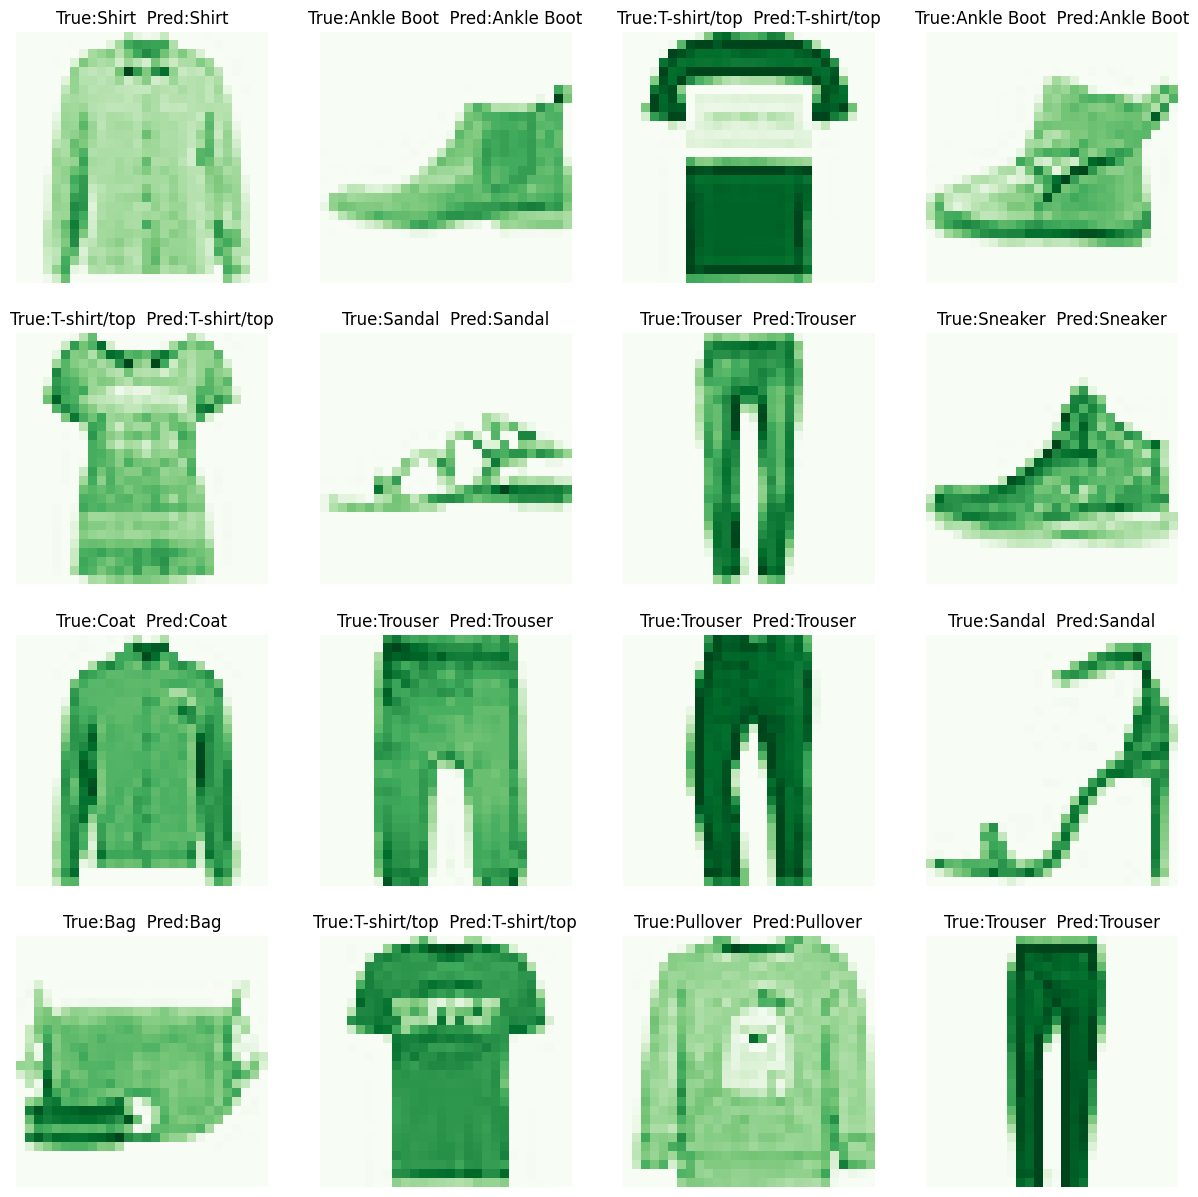

In [ ]:
def plot_images(data_index, pred_classes, y_true, cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(4,4, figsize=(15,15))
    for i, indx in enumerate(data_index[:16]):
        ax[i//4, i%4].imshow(x_val[indx].reshape(IMG_ROWS,IMG_COLS), cmap=cmap)
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title("True:{}  Pred:{}".format(labels[y_true[indx]],labels[pred_classes[indx]]))
    plt.show()    
    
plot_images(correct, pred_y_val, y_val, "Greens")

## <a id="62">Incorrectly classified images</a>

Let's see also few images incorrectly classified.

* **0**: **T-shirt/top**;   
* **1**: **Trouser**;   
* **2**: **Pullover**;   
* **3**: **Dress**;
* **4**: **Coat**;
* **5**: **Sandal**;
* **6**: **Shirt**;
* **7**: **Sneaker**;
* **8**: **Bag**;
* **9**: **Ankle boot**.

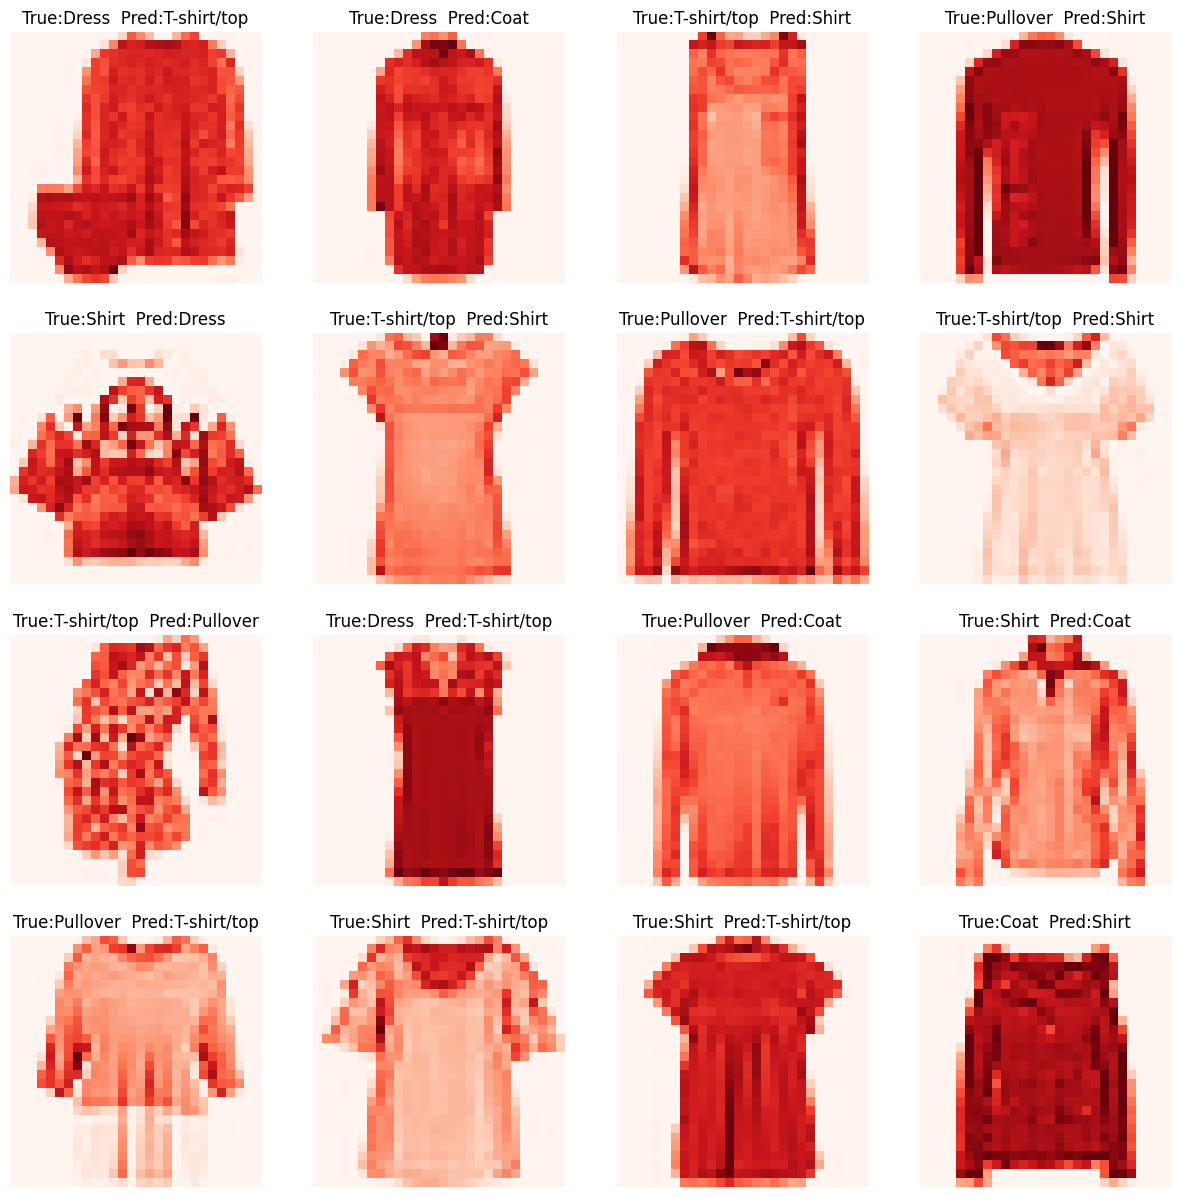

In [ ]:
plot_images(incorrect, pred_y_val, y_val, "Reds")

# Test Kaggle загрузка

In [ ]:
fmnist_test = pd.read_csv('/content/mds-mipt-dl-test/fmnist_test.csv', index_col='Id')
x_test = fmnist_test.to_numpy()
x_test.shape

(10000, 784)

In [ ]:
to_pred = x_test.reshape((x_test.shape[0], 28, 28))[:,:, :, np.newaxis]
to_pred = images_norm(to_pred)
y_test = np.argmax(network_fashon.predict(to_pred), axis = 1)


313/313 [==============================] - 146s 465ms/step


9238

# Сабмит в Kaggle сразу

In [ ]:
submission = pd.DataFrame()
# записываем ответы
submission['Category'] = y_test
submission.index.name = 'Id'

file_name = 'submission.csv'
# сохраняем с колонкой Id
submission.to_csv(file_name, 
                  index_label = 'Id')

In [ ]:
!kaggle competitions submit -c mds-mipt-dl-test-final -f submission.csv -m "from colab_note unet4"

100% 67.3k/67.3k [00:00<00:00, 304kB/s]
Successfully submitted to [MDS-MIPT-DL-TEST] Классификация изображений